# 0. Imports

In [21]:
# 1. Lendos os dados
import pandas as pd
import numpy as np
from pathlib import Path

# 2. Pré-processamento dos Textos
import re
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# 3. Balanceamento das classes
from sklearn.model_selection import train_test_split

# 4. Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer

#5. Classificação
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Teste
from sklearn.feature_selection import RFE, mutual_info_classif

[nltk_data] Downloading package stopwords to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/esdras-
[nltk_data]     daniel/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# 1. Lendo os dados

In [12]:
path = Path('./data/pgm-dataset-v2.parquet')
df = pd.read_parquet(path)

df.head(3)

,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Sa�de,
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,
2,,,"[{""diligencia"": ""Decido. Compulsando os autos,...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629422"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08954169320228205001"", ""Competenci...",18629422,CARTORIO,


## 1.1 - Criando um nova coluna de classe

### 1.1.1 - Corrigindo erros prévios

In [14]:
# Substituindo os valores da coluna 'setordestino'

swap_dict = {
    'DEPARTAMENTO DE C�LCULOS E CONTABILIDADE': 'DEPARTAMENTO DE CALCULOS E CONTABILIDADE',
    'Procuradoria da Sa�de': 'Procuradoria da Saude',
    'SETOR DE ADMINISTRA�?O GERAL': 'SETOR DE ADMINISTRACAO GERAL',
    'Procuradoria de Recupera�?o da D�vida Ativa': 'Procuradoria de Recuperacao da Divida Ativa'
}

df['setordestino'].replace(swap_dict, inplace=True)

/tmp/ipykernel_564851/697653990.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['setordestino'].replace(swap_dict, inplace=True)


### 1.1.2 - Definindo as novas classes

In [15]:
swap_dict = {
    'Procuradoria Administrativa': 'Administrativa',
    'Chefia Administrativa': 'Administrativa',

    'Procuradoria Fiscal': 'Fiscal',
    'APOIO FISCAL': 'Fiscal',
    'CHEFIA FISCAL': 'Fiscal',

    'Procuradoria da Saude': 'Saude',

    'Procuradoria Judicial': 'Judicial',
    'Chefia Judicial': 'Judicial',

    'Chefia Meio Ambiente': 'Meio Ambiente',
    'Procuradoria do Meio Ambiente': 'Meio Ambiente',

    'Chefia Patrimonial': 'Patrimonio',

    'DEPARTAMENTO DE CALCULOS E CONTABILIDADE': 'Contabilidade',

    'Assessoria - Gabinete': 'Geral',
    'Procuradoria Geral': 'Geral',
}

df['general_classes'] = df['setordestino'].map(swap_dict)

In [16]:
df.head(3)

,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao,general_classes
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Saude,,Saude
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,,Administrativa
2,,,"[{""diligencia"": ""Decido. Compulsando os autos,...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629422"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08954169320228205001"", ""Competenci...",18629422,CARTORIO,,NaN


In [17]:
print(df.shape)
print(df.info())

(15984, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15984 entries, 0 to 15983
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   intimacao_conteudo  15984 non-null  object
 1   processo_conteudo   15984 non-null  object
 2   rstREGEX            15942 non-null  object
 3   teorIntimacao       15942 non-null  object
 4   intimacaoPJE        15942 non-null  object
 5   processoPJE         15942 non-null  object
 6   idavisopje          15356 non-null  object
 7   setordestino        15356 non-null  object
 8   Classificacao       15984 non-null  object
 9   general_classes     15347 non-null  object
dtypes: object(10)
memory usage: 1.2+ MB
None


## 1.2 - Removendo valores nulos

In [18]:
docs_nulos = df.general_classes.isna()

print(f'Temos {docs_nulos.sum()} documentos onde "general_classes" ou "setordestino" é nulo')

# Removendo
df.dropna(axis=0, how='any', inplace=True)

Temos 637 documentos onde "general_classes" ou "setordestino" é nulo


# 2. Pré-processamento dos Textos

In [22]:
stop_words_pt = set(stopwords.words('portuguese'))

padroes = ['[^\w\s]',
        'poder judiciario do estado do rio grande do norte',
        'poder judiciario estado do rio grande do norte',
        'poder judiciario do estado rio grande do norte',
        'poder judiciario estado rio grande do norte',
        'normal', 'false',
            'ptbr', 'xnone',
            'poder', 'judiciario',
            'estado', 'rio', 'grande', 'norte',
            'vara execucao fiscal',
            'tributaria natal',
            'praca sete setembro',
            'cidade alta',
            'natalrn', 'cep',
            'rn', 'natal', '5902530',
            'assinado', 'digitalmente',
            'forma lei', 'n1141906',
            'comarca', 'forum fazendario',
            'juiz djanirito souza moura',
            'data registrada sistema',
            '1141906', 'veft', '59025275', 'email',
            'secuniefttj', 'jusbr',
            'telefone', 'whatsapp',
            '36738671',
            'judiciario', 'natalpraca',
            'setembro', 'cidade', '59025300',
            'rio norte', 'forum fazendario',
            'juiz', 'djanirito souza mouro',
            'praca alto', 'natalrn', 'nao',
            # Palavras escluidas após a conversa com Nailton dia 07/01/25
            'lei',
    ]

def preprocessamento(text):
    if text == None:
        return text
    
    text_tokens = word_tokenize(text, language='portuguese')

    filtered_text = [word for word in text_tokens if word.lower() not in stop_words_pt and len(word) > 2]
    text = ' '.join(filtered_text)

    # Retira acentos e converte o texto para minúsculo
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII').lower()

    # Retira alguns padrões definidos na lista 'padroes'
    for padrao in padroes:
        text = re.sub(padrao, '', text)

    return text


<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_564851/3204766781.py:3: SyntaxWarning: invalid escape sequence '\w'
  padroes = ['[^\w\s]',


In [23]:
df['teorIntimacao_clean'] = df['teorIntimacao'].apply(preprocessamento)

df.head(3)

,intimacao_conteudo,processo_conteudo,rstREGEX,teorIntimacao,intimacaoPJE,processoPJE,idavisopje,setordestino,Classificacao,general_classes,teorIntimacao_clean
0,,,"[{""diligencia"": ""intime-se o Município de Nata...",PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,"{""id"": ""18612632"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08387198120248205001"", ""Competenci...",18612632,Procuradoria da Saude,,Saude,vara infancia juventude processo no083...
1,,,"[{""diligencia"": ""intimado acerca da obrigação ...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629258"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""08464942120228205001"", ""Competenci...",18629258,Procuradoria Administrativa,,Administrativa,3o ado fazenda publica processo 0846494...
3,,,"[{""diligencia"": ""intime-se a parte exequente p...",PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,"{""id"": ""18629665"", ""tipoComunicacao"": ""INT"", ""...","{""Numero"": ""01263147320118200001"", ""Competenci...",18629665,APOIO FISCAL,,Fiscal,5a 0 numero processo 012631473201182...


In [24]:
df.general_classes.value_counts()

general_classes
Fiscal            6686
Administrativa    5401
Contabilidade     1338
Judicial          1137
Saude              443
Meio Ambiente      155
Patrimonio         121
Geral               66
Name: count, dtype: int64

# 3. Balanceamento de classes

In [25]:
def ajustar_amostras(df, classes, n_docs):
    """
    Ajusta o número de amostras (upsampling ou downsampling) para cada classe em um DataFrame.
    
    Parâmetros:
    - df (pd.DataFrame): DataFrame original.
    - classes (str): Nome da coluna que contém as classes.
    - n_docs (int): Número desejado de documentos por classe.
    
    Retorno:
    - pd.DataFrame: DataFrame ajustado com a quantidade especificada de documentos por classe.
    """
    def ajustar_classe(grupo):
        if len(grupo) > n_docs:
            # Downsampling
            return grupo.sample(n_docs, random_state=42)
        else:
            # Upsampling
            return grupo.sample(n_docs, replace=True, random_state=42)
    
    return df.groupby(classes).apply(ajustar_classe).reset_index(drop=True)

df_ajustado = ajustar_amostras(df, 'general_classes', n_docs=500)

/tmp/ipykernel_564851/2055252691.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(classes).apply(ajustar_classe).reset_index(drop=True)


In [ ]:
df_ass

In [26]:
df_ajustado.general_classes.value_counts()

general_classes
Administrativa    500
Contabilidade     500
Fiscal            500
Geral             500
Judicial          500
Meio Ambiente     500
Patrimonio        500
Saude             500
Name: count, dtype: int64

## 3.1 - Train Test Split

In [27]:
X = df_ajustado['teorIntimacao_clean'].to_numpy()
y = df_ajustado['general_classes'].to_numpy()
classes = np.unique(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print(f'Shape Treinamento: {X_train.shape}')
print(f'Shape Teste: {X_test.shape}')

Shape Treinamento: (2800,)
Shape Teste: (1200,)


# 4. Feature Extraction

In [28]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.005, ngram_range=(1,2))

# Fazendo o fitting nos dados de treinamento apenas e vetorizando-os
X_train = tfidf_vectorizer.fit_transform(X_train)

# Fazendo a vetorização dos dados de teste
X_test = tfidf_vectorizer.transform(X_test)

print(f'Shape do trainamento: {X_train.shape}')
print(f'Shape do teste: {X_test.shape}')

Shape do trainamento: (2800, 15665)
Shape do teste: (1200, 15665)


# 5. Classificação

## 5.0 - Funções

In [29]:
def plot_confusion_matrix(y_test, y_pred, class_names):
    # Calcula a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Normaliza a matriz para valores entre 0 e 1
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Cria o gráfico
    plt.figure(figsize=(10, 8))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão', fontsize=16)
    plt.colorbar()
    
    # Adiciona rótulos
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, fontsize=6)
    plt.yticks(tick_marks, class_names, fontsize=6)
    
    # Adiciona os valores na matriz
    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black",
                 fontsize=10)
    
    plt.ylabel('Classe Real', fontsize=14)
    plt.xlabel('Classe Prevista', fontsize=14)
    plt.tight_layout()
    plt.show()

def feature_importance_analysis(tfidf_matrix, y, class_labels, feature_names):
    df_dict = dict()

    for i, label in enumerate(class_labels):
        class_tfidf_means = tfidf_matrix[y == label].mean(axis=0).A1
        #top_indices = np.argsort(class_tfidf_means)[::-1]
        df_dict[label] = class_tfidf_means

    return_df = pd.DataFrame(data=df_dict, index=feature_names)
        
    return return_df

def plot_top_terms(dataframe, n):
    """
    Gera um gráfico com subplots contendo tabelas para os top n termos
    de cada classe em um DataFrame.

    Parâmetros:
        dataframe (pd.DataFrame): DataFrame onde as colunas são classes,
                                  os índices são termos, e os dados são os valores médios TF-IDF.
        n (int): Quantidade de termos para exibir em cada classe.
    """
    # Número de classes
    classes = dataframe.columns
    num_classes = len(classes)

    # Configuração do layout do plot
    cols = 3
    rows = int(np.ceil(num_classes/cols))

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 4 * rows))
    axes = axes.flatten()

    # Iterar sobre cada classe e criar a tabela
    for i, (classe, ax) in enumerate(zip(classes, axes)):
        # Obter os n termos com maiores valores médios para a classe
        top_terms = dataframe[classe].nlargest(n).round(5)
        
        # Criar a tabela para o subplot
        ax.axis('tight')
        ax.axis('off')
        table_data = list(zip(top_terms.index, top_terms.values))
        ax.table(
            cellText=table_data,
            colLabels=["Termo", "Valor Médio"],
            cellLoc='center',
            loc='center'
        )
        ax.set_title(f"Classe: {classe}", fontsize=14)

    # Ajustar o layout geral
    plt.tight_layout()
    plt.show()

## 5.1 - Random Forest

In [30]:
random_forest_clf = RandomForestClassifier(criterion='entropy')
random_forest_clf.fit(X_train, y_train)

y_pred = random_forest_clf.predict(X_test)

In [31]:
print(classification_report(y_true=y_test, y_pred=y_pred))

                precision    recall  f1-score   support

Administrativa       0.71      0.56      0.62       167
 Contabilidade       0.93      0.97      0.95       148
        Fiscal       0.94      0.89      0.91       158
         Geral       0.90      0.99      0.94       149
      Judicial       0.69      0.53      0.60       159
 Meio Ambiente       0.88      0.92      0.90       135
    Patrimonio       0.79      1.00      0.88       134
         Saude       0.85      0.95      0.90       150

      accuracy                           0.84      1200
     macro avg       0.84      0.85      0.84      1200
  weighted avg       0.83      0.84      0.83      1200



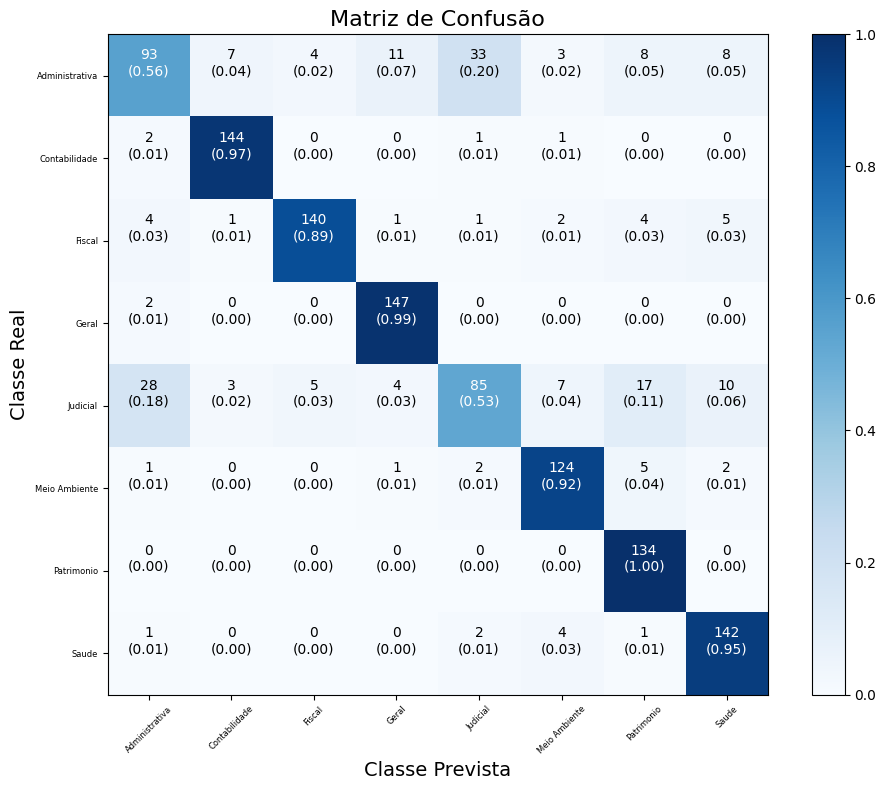

In [32]:
plot_confusion_matrix(y_test=y_test, y_pred=y_pred, class_names=classes)

### 5.1.1 - Análise de Features

In [33]:
df_teste = feature_importance_analysis(tfidf_matrix=X_test, y=y_pred, class_labels=classes, feature_names=tfidf_vectorizer.get_feature_names_out())

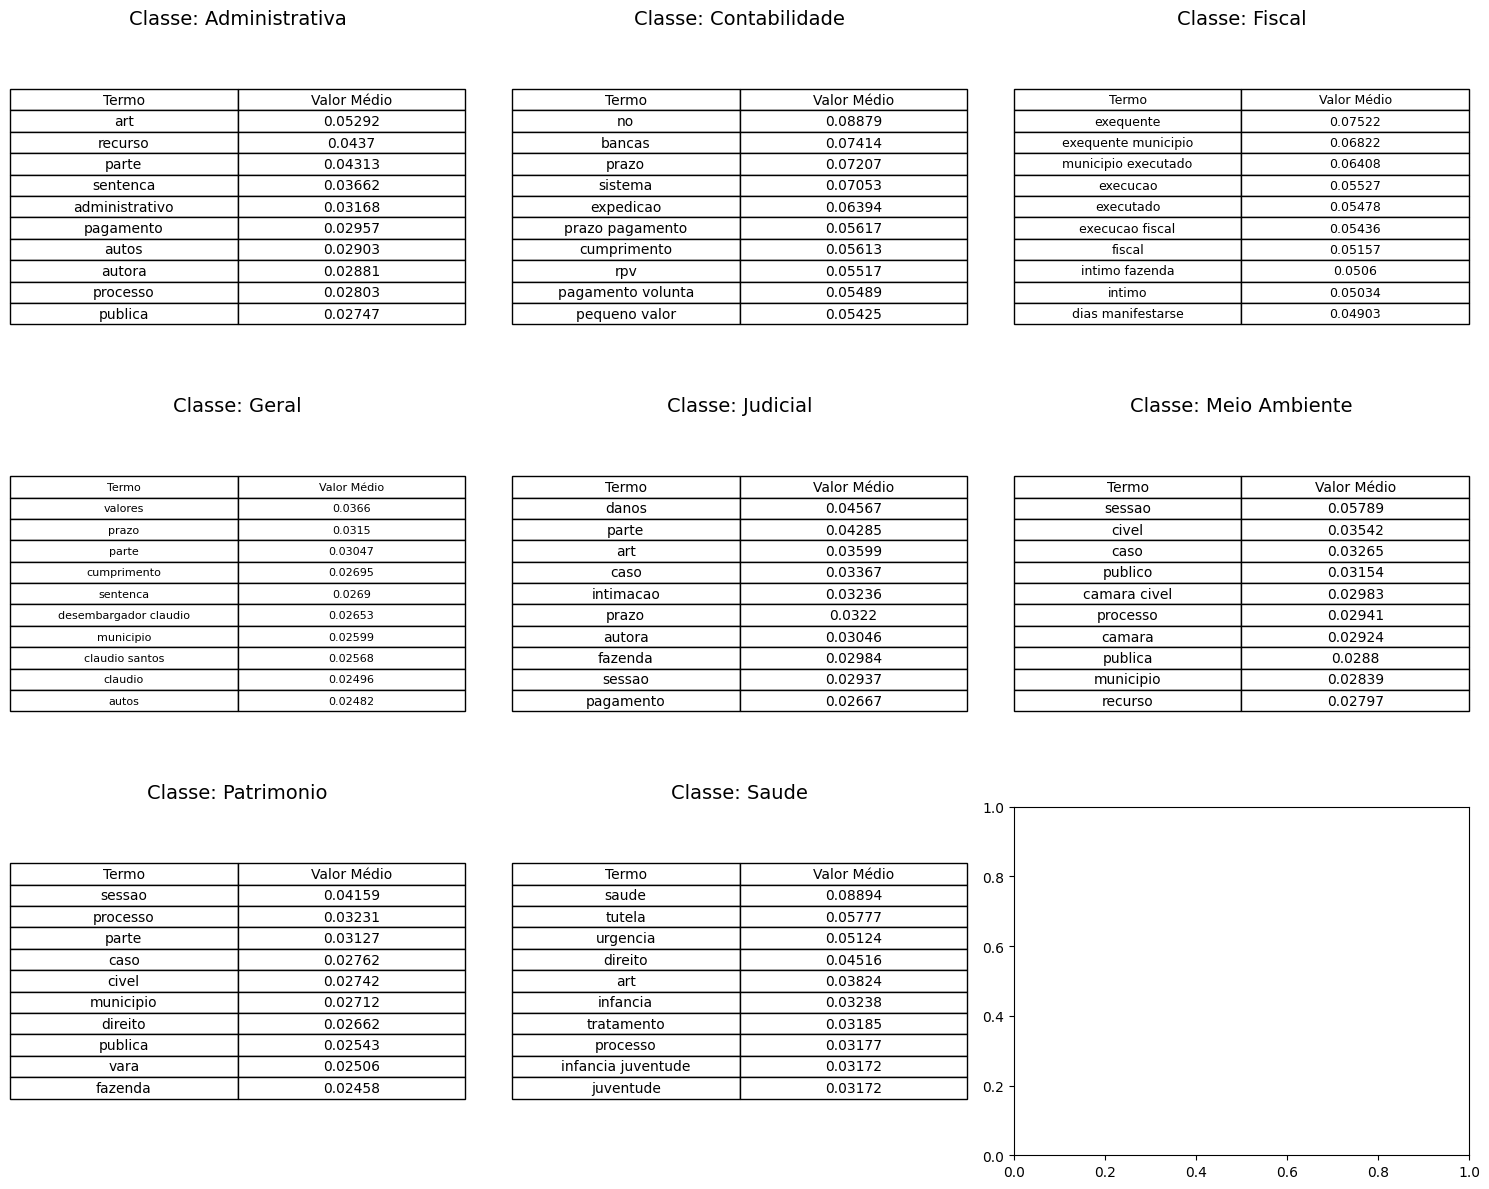

In [34]:
plot_top_terms(dataframe=df_teste, n=10)

## 5.2 - XGBoost

In [35]:
sub_dict = {classe: i for i, classe in enumerate(classes)}

y_train_temp = [sub_dict[i] for i in y_train]
y_test_temp = [sub_dict[i] for i in y_test]

xgboost_clf = XGBClassifier()
xgboost_clf.fit(X_train, y_train_temp)

y_pred = xgboost_clf.predict(X_test)

In [36]:
print(classification_report(y_true=y_test_temp, y_pred=y_pred, target_names=classes))

                precision    recall  f1-score   support

Administrativa       0.74      0.57      0.65       167
 Contabilidade       0.92      0.99      0.95       148
        Fiscal       0.95      0.89      0.92       158
         Geral       0.91      0.99      0.95       149
      Judicial       0.70      0.62      0.66       159
 Meio Ambiente       0.85      0.93      0.89       135
    Patrimonio       0.87      1.00      0.93       134
         Saude       0.88      0.95      0.91       150

      accuracy                           0.86      1200
     macro avg       0.85      0.87      0.86      1200
  weighted avg       0.85      0.86      0.85      1200



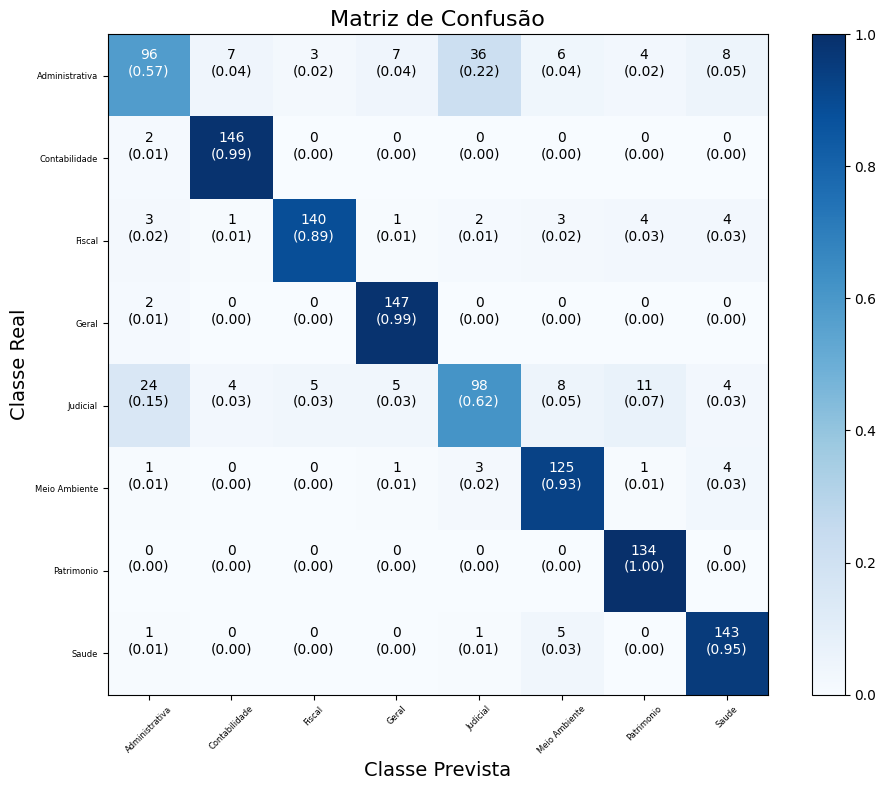

In [37]:
plot_confusion_matrix(y_test=y_test_temp, y_pred=y_pred, class_names=classes)